<a href="https://colab.research.google.com/github/Soumi7/Table_Data_Extraction/blob/main/medium_table.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading original image to display

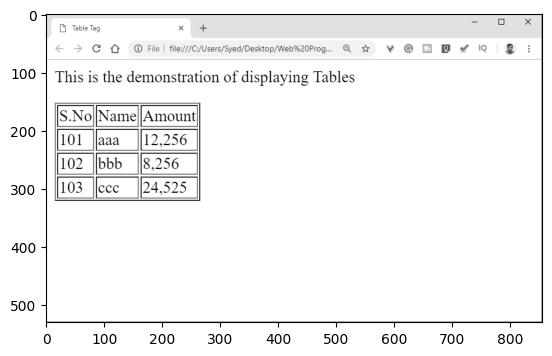

In [344]:
import cv2
import matplotlib.pyplot as plt
file=r'./test_table_img.png'
img = cv2.imread(file,0)
plot1 = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

## Inverted Image with global thresh holding

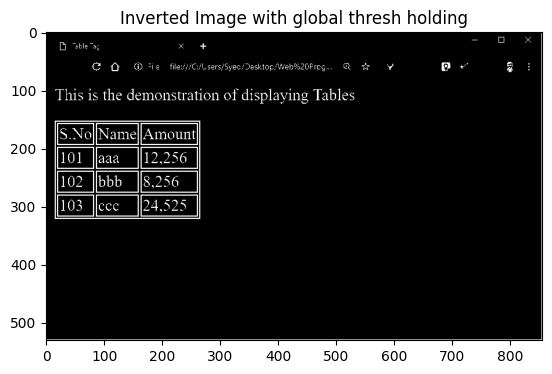

In [345]:
thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY)
img_bin = 255-img_bin
plotting = plt.imshow(img_bin,cmap='gray')
plt.title("Inverted Image with global thresh holding")
plt.show()

## Inverted Image with otsu thresh holding

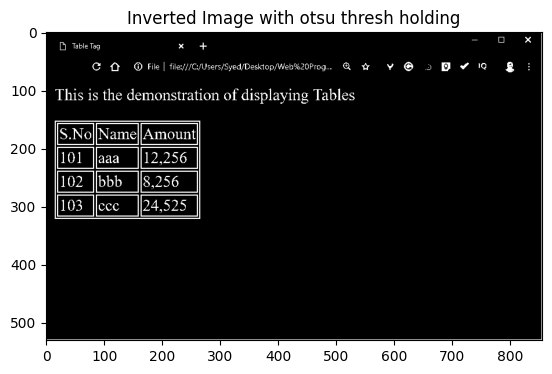

In [346]:
img_bin1 = 255-img
thresh1,img_bin1_otsu = cv2.threshold(img_bin1,128,255,cv2.THRESH_OTSU)
plotting = plt.imshow(img_bin1_otsu,cmap='gray')
plt.title("Inverted Image with otsu thresh holding")
plt.show()

## Inverted image with both global and Otsu thresholding

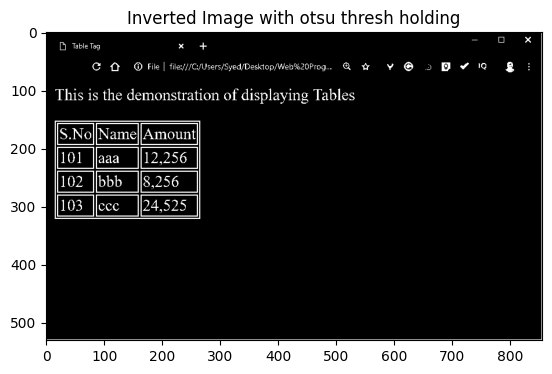

In [347]:
img_bin2 = 255-img
thresh1,img_bin_otsu = cv2.threshold(img_bin2,128,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plotting = plt.imshow(img_bin_otsu,cmap='gray')
plt.title("Inverted Image with otsu thresh holding")
plt.show()

## Create a rectangular structuring element

In [348]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
print(kernel)

[[1 1]
 [1 1]]


# Morphological Operations

## Create a new structuring element to perform erosion on the image

First we need to get the vertical lines.

We create a vertical kernel with kernel width 1 and height the number of columns in image array divided by 200.

Erosion makes the pixel 1 only if all the pixels under kernel are 1.

We perform erosion for 5 iterations with the vertical kernel.

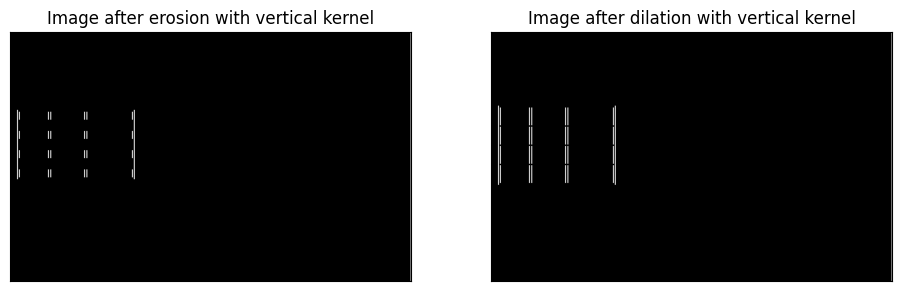

In [349]:
import numpy as np
plt.figure(figsize= (30,30))

vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, np.array(img).shape[1]//100))
eroded_image = cv2.erode(img_bin_otsu, vertical_kernel, iterations=3)
plt.subplot(151),plt.imshow(eroded_image, cmap = 'gray')
plt.title('Image after erosion with vertical kernel'), plt.xticks([]), plt.yticks([])

vertical_lines = cv2.dilate(eroded_image, vertical_kernel, iterations=3)
plt.subplot(152),plt.imshow(vertical_lines, cmap = 'gray')
plt.title('Image after dilation with vertical kernel'), plt.xticks([]), plt.yticks([])

plt.show()

Dilation will make the pixel 1, if at least one of the pixels under the kernel is 1.

Similarly lets do the same with a horizontal lines to get the horizontal lines.

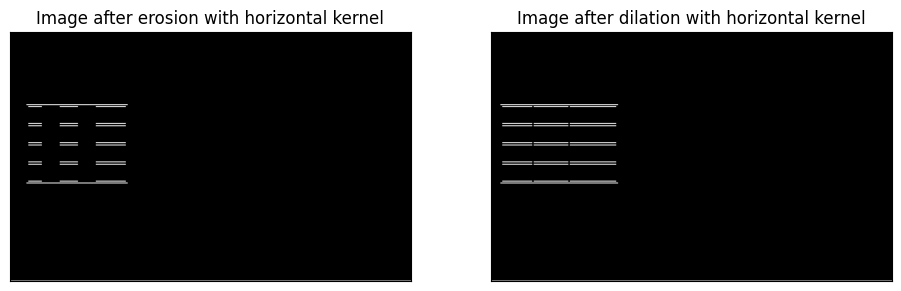

In [350]:
plt.figure(figsize= (30,30))

hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (np.array(img).shape[1]//100, 1))
horizontal_lines = cv2.erode(img_bin, hor_kernel, iterations=5)
plt.subplot(153),plt.imshow(horizontal_lines, cmap = 'gray')
plt.title('Image after erosion with horizontal kernel'), plt.xticks([]), plt.yticks([])

horizontal_lines = cv2.dilate(horizontal_lines, hor_kernel, iterations=5)
plt.subplot(154),plt.imshow(horizontal_lines, cmap = 'gray')
plt.title('Image after dilation with horizontal kernel'), plt.xticks([]), plt.yticks([])

plt.show()

## Now we add the two images

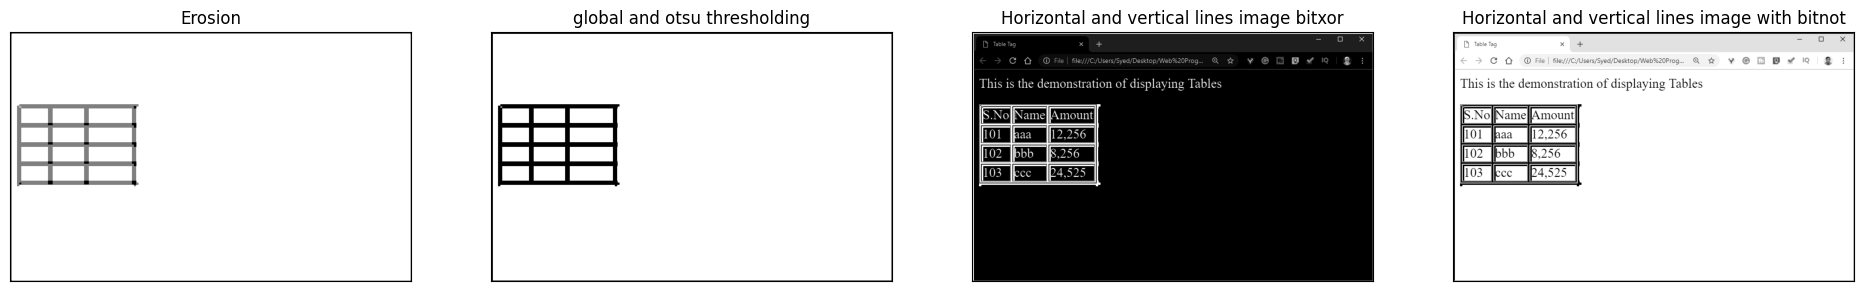

In [351]:
plt.figure(figsize= (30,30))

vertical_horizontal_lines = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
vertical_horizontal_lines = cv2.erode(~vertical_horizontal_lines, kernel, iterations=3)
plt.subplot(151),plt.imshow(vertical_horizontal_lines, cmap = 'gray')
plt.title('Erosion'), plt.xticks([]), plt.yticks([])

thresh, vertical_horizontal_lines = cv2.threshold(vertical_horizontal_lines,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.subplot(152),plt.imshow(vertical_horizontal_lines, cmap = 'gray')
plt.title('global and otsu thresholding'), plt.xticks([]), plt.yticks([])

bitxor = cv2.bitwise_xor(img,vertical_horizontal_lines)
plt.subplot(153),plt.imshow(bitxor, cmap = 'gray')
plt.title('Horizontal and vertical lines image bitxor'), plt.xticks([]), plt.yticks([])

bitnot = cv2.bitwise_not(bitxor)
plt.subplot(154),plt.imshow(bitnot, cmap = 'gray')
plt.title('Horizontal and vertical lines image with bitnot'), plt.xticks([]), plt.yticks([])

plt.show()

In [352]:
!pip install pytesseract
!sudo apt install tesseract-ocr


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
'sudo' is not recognized as an internal or external command,
operable program or batch file.


In [353]:
import pytesseract

## Let's get the contours from the grid that we have obtained by adding the horizontal and vertical lines.

In [354]:
contours, hierarchy = cv2.findContours(vertical_horizontal_lines, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

## Bounding Boxes

To get the coordinates of different boxes

In [355]:
boundingBoxes = [cv2.boundingRect(contour) for contour in contours]
(contours, boundingBoxes) = zip(*sorted(zip(contours, boundingBoxes),key=lambda x:x[1][1]))

Here we draw the contours on our image and also store them in list boxes. It is stored as a list (x,y,w,h) : x and y beind coordinates of top left corner and w and h being width and height of the box respectively.

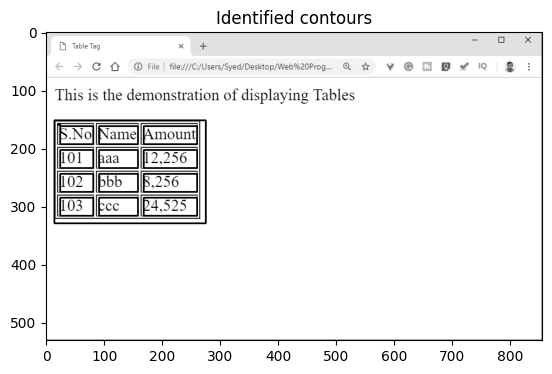

In [356]:
boxes = []
for contour in contours:
  x, y, w, h = cv2.boundingRect(contour)
  if (w<1000 and h<500):
    image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    boxes.append([x,y,w,h])
plotting = plt.imshow(image,cmap='gray')
plt.title("Identified contours")
plt.show()

## Getting the rows and columns

## To store rows and columns :

- Now we add rows and columns.
- We calculate the mean height of all boxes.
- Initially, we append the first box to the columns list.
- The columns list is essentialy a temporary list.
- We assign previous box to the first box as well.
- We will loop through the remaining boundingBoxes list.
- At each iteration, we check if the y coordinate of the top left corner of the current box is less than the y coordinate of the previous box added with half the mean of all heights.
- If yes :
    - The current box is appended to columns list.
    - The current box is assigned to previous box.
    - Next we check if we are at the last index. If yes :
      - We append the entire column to rows list.
- If no :
    - We append the columns list to rows.
    - We assign the columns list to empty as this will start a new empty columns list.
    - We assign the current box to the previous box variable.
    - We append the current box to the empty column list we just created.


In [357]:
rows=[]
columns=[]
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
mean = np.mean(heights)
print(mean)
columns.append(boxes[0])
previous=boxes[0]
for i in range(1,len(boxes)):
  if(boxes[i][1]<=previous[1]+mean/2):
    columns.append(boxes[i])
    previous=boxes[i]
    if(i==len(boxes)-1):
      rows.append(columns)
  else:
    rows.append(columns)
    columns=[]
    previous = boxes[i]
    columns.append(boxes[i])
print("Rows")
for row in rows:
  print(row)

71.8
Rows
[[14, 153, 261, 177], [20, 159, 4, 2], [168, 163, 92, 31], [91, 163, 67, 31], [24, 163, 57, 31]]
[[168, 204, 92, 31], [91, 204, 67, 31], [24, 204, 57, 31]]
[[168, 245, 92, 31], [91, 245, 67, 31], [24, 245, 57, 31]]
[[168, 286, 92, 31], [91, 286, 67, 31], [24, 286, 57, 31]]


Lets get the total cells in each row

In [358]:
total_cells=0
for i in range(len(row)):
  if len(row[i]) > total_cells:
    total_cells = len(row[i])
print(total_cells)

4


# Lets get the centre of cell

- We add the width of cell to left bottom x coordinate to the the x coordinate of centre of cell.

In [359]:
center = [int(rows[i][j][0]+rows[i][j][2]/2) for j in range(len(rows[i])) if rows[0]]
print(center)

[214, 124, 52]


In [360]:
center=np.array(center)
center.sort()
print(center)

[ 52 124 214]


# Now we create a list of the coordinates of the boxes

In [ ]:
boxes_list = []
for i in range(len(rows)):
    l=[]
    for k in range(total_cells):
        l.append([])
    for j in range(len(rows[i])):
        diff = abs(center-(rows[i][j][0]+rows[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        l[indexing].append(rows[i][j])
    boxes_list.append(l)
for box in boxes_list:
  print(box)

[[[14, 153, 261, 177], [20, 159, 4, 2], [24, 163, 57, 31]], [[91, 163, 67, 31]], [[168, 163, 92, 31]], []]
[[[24, 204, 57, 31]], [[91, 204, 67, 31]], [[168, 204, 92, 31]], []]
[[[24, 245, 57, 31]], [[91, 245, 67, 31]], [[168, 245, 92, 31]], []]
[[[24, 286, 57, 31]], [[91, 286, 67, 31]], [[168, 286, 92, 31]], []]


## Extract image from the boxes and get the contents using pytesseract

- We extract the region of interest from the image.
- For the cell we resize it, then perform morphological operations on the extracted cell area to remove noise.
- Finally, we use pytesseract to convert the image to a string.
- We append the strings in each row first to temporary string s with spaces, and then we append this temporary string to the final dataframe.

In [230]:
dataframe_final=[]
for i in range(len(boxes_list)):
    for j in range(len(boxes_list[i])):
        s=''
        if(len(boxes_list[i][j])==0):
            dataframe_final.append(' ')
        else:
            for k in range(len(boxes_list[i][j])):
                y,x,w,h = boxes_list[i][j][k][0],boxes_list[i][j][k][1], boxes_list[i][j][k][2],boxes_list[i][j][k][3]
                roi = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(roi,2,2,2,2, cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=2)                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion)
                s = s +" "+ out
            dataframe_final.append(s)
print(dataframe_final)

['  \n\nIo I I\n\x0c \x0c S.No\n\x0c', ' Name\n\x0c', ' Amount\n\x0c', ' ', ' 101\n\x0c', ' aaa\n\x0c', ' 12,256\n\x0c', ' ', ' 102\n\x0c', ' bbb\n\x0c', ' 8,256\n\x0c', ' ', ' 103\n\x0c', ' ccc\n\x0c', ' 24,525\n\x0c', ' ']


## Next we create a Numpy array from the dataframe

In [231]:
arr = np.array(dataframe_final)
arr

array(['  \n\nIo I I\n\x0c \x0c S.No\n\x0c', ' Name\n\x0c',
       ' Amount\n\x0c', ' ', ' 101\n\x0c', ' aaa\n\x0c', ' 12,256\n\x0c',
       ' ', ' 102\n\x0c', ' bbb\n\x0c', ' 8,256\n\x0c', ' ', ' 103\n\x0c',
       ' ccc\n\x0c', ' 24,525\n\x0c', ' '], dtype='<U21')

## **Creating a dataframe from extracted data**

- We reshape our array into a dataframe with the number of rows and columns.
- Lets print out the columns and check!

In [234]:
import pandas as pd
dataframe = pd.DataFrame(arr.reshape(len(rows), total_cells))
data = dataframe.style.set_properties(align="left")
#print(data)
#print(dataframe)
d=[]
for i in range(0,len(rows)):
  for j in range(0,total_cells):
    print(dataframe[i][j],end=" ")
  print()

  

Io I I
  S.No
  101
  102
  103
 
 Name
  aaa
  bbb
  ccc
 
 Amount
  12,256
  8,256
  24,525
 
        


## Printing Dataframe

In [208]:
print(dataframe)

                           0         1           2  3
0    \n\nIo I I\n  S.No\n   Name\n   Amount\n   
1                     101\n    aaa\n   12,256\n   
2                     102\n    bbb\n    8,256\n   
3                     103\n    ccc\n   24,525\n   


#### Final task is to save this data into a csv format for further uses.

- A output.csv file is generated in google colab. You can download it.

In [205]:
dataframe.to_csv("output.csv")